In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [2]:
def plotting_comparison(predictions, title = 'XGB'):
    plt.gcf().set_size_inches(10, 7)
    plt.plot(predictions, label = 'predictions')
    plt.plot(test_y, label = 'true value')
    plt.legend(loc='upper left')
    plt.title(title + ' model')
    plt.show()

In [3]:
df = pd.read_csv('Check flow.csv', delimiter = ';', encoding = 'latin-1', on_bad_lines='skip', engine='python')
df.columns = ['date', 'check_flow']
df = df.dropna(axis=0)
df.drop(index = df.index[-1], axis = 0, inplace=True)
df.index = np.arange(0,len(df))
df.check_flow = df.check_flow.astype('int')
df.date = pd.to_datetime(df.date.apply(lambda x:str(x).replace('.','-')), dayfirst = True)
split_date =  pd.to_datetime('2022-07-01')
split_index = df[df.date ==  split_date].index.astype('int')[0]
df.tail()

,date,check_flow
870,2022-08-27,245
871,2022-08-28,218
872,2022-08-29,182
873,2022-08-30,190
874,2022-08-31,180


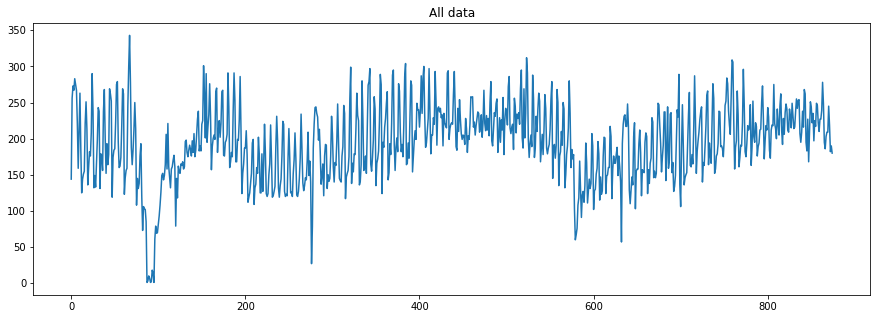

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df.check_flow.values)
plt.title('All data')
plt.show()

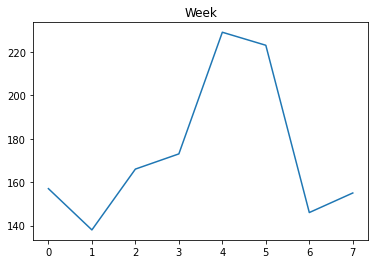

In [ ]:
plt.plot(df[(df.date >= pd.to_datetime('2022-02-01')) & (df.date <= pd.to_datetime('2022-02-08'))].check_flow.values)
plt.title('Week')
plt.show()

In [5]:
def create_features(df): # создание дополнительных столбцов для градиентного бустинга
    df['dayofweek'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofyear'] = df.date.dt.dayofyear
create_features(df)

In [6]:
train, test = df[df.date < split_date], df[df.date > split_date]
train.shape, test.shape
x_columns = ['dayofweek', 'month', 'year']
train_x,train_y = train[x_columns].values, train[['check_flow']].values
test_x, test_y = test[x_columns].values, test[['check_flow']].values

In [7]:
import xgboost as xgb # Gradient Boosting
regr_xgb = xgb.XGBRegressor(n_estimators = 1160, early_stopping_rounds = 50)
regr_xgb.fit(train_x,train_y, eval_set = [(train_x,train_y), (test_x, test_y)], verbose=100)

[15:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:179.557	validation_1-rmse:204.389
[100]	validation_0-rmse:31.4219	validation_1-rmse:18.1695
[200]	validation_0-rmse:30.3871	validation_1-rmse:18.3648
[300]	validation_0-rmse:30.1354	validation_1-rmse:18.1907
[400]	validation_0-rmse:29.988	validation_1-rmse:17.7965
[500]	validation_0-rmse:29.9077	validation_1-rmse:17.7481
[600]	validation_0-rmse:29.8357	validation_1-rmse:17.6235
[700]	validation_0-rmse:29.7748	validation_1-rmse:17.6285
[800]	validation_0-rmse:29.7357	validation_1-rmse:17.566
[900]	validation_0-rmse:29.6986	validation_1-rmse:17.4466
[1000]	validation_0-rmse:29.6683	validation_1-rmse:17.3812
[1100]	validation_0-rmse:29.6428	validation_1-rmse:17.3926
[1159]	validation_0-rmse:29.6319	validation_1-rmse:17.2913


XGBRegressor(early_stopping_rounds=50, n_estimators=1160)

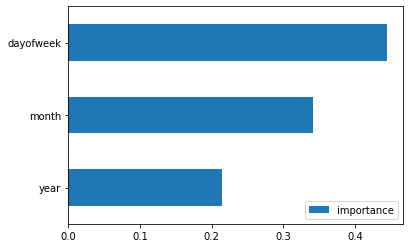

In [ ]:
importance = pd.DataFrame(data = regr_xgb.feature_importances_, index = x_columns, columns = ['importance']) # важность 
importance.sort_values('importance').plot(kind='barh')
plt.show()

In [8]:
predictions = regr_xgb.predict(test_x)
print('R2 score:', r2_score(test_y, predictions))
print('MAPE:', mean_absolute_percentage_error(test_y, predictions))
print('RMSE:', (mean_squared_error(test_y, predictions))**0.5)
print('MAE: ', mean_absolute_error(test_y, predictions))
metrics_xgb = [[r2_score(test_y, predictions), mean_absolute_percentage_error(test_y, predictions), mean_squared_error(test_y, predictions)**0.5, mean_absolute_error(test_y, predictions)]]

R2 score: 0.4896315024738124
MAPE: 0.0610194589984896
RMSE: 17.29132956253355
MAE:  13.467908015016649


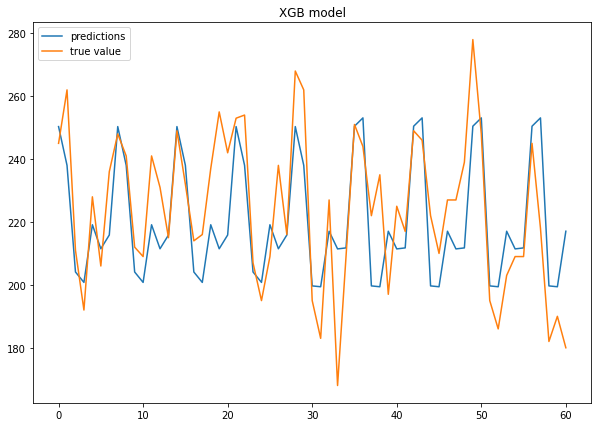

In [ ]:
plotting_comparison(predictions)

In [9]:
from statsmodels.tsa.stattools import adfuller # проверка данных на стационарность, чтобы выбрать, использовать ARIMA или SARIMAX
dftest = adfuller(df.check_flow, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.1596800601392396
2. P-Value :  0.02244043093531189
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 854
5. Critical Values :
	 1% :  -3.43803040357387
	 5% :  -2.864930295955726
	 10% :  -2.568575256706284


In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.7 MB/s 
     |████████████████████████████████| 9.8 MB 42.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
from pmdarima import auto_arima # Поиск подходящих параметров для модели ARIMA
import warnings
auto = auto_arima(df.check_flow, trace=True, suppress_warnings = True)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8679.626, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8980.982, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8979.898, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8944.276, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8978.987, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8716.821, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8704.633, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8704.691, Time=1.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8607.181, Time=2.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8716.980, Time=1.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8586.624, Time=2.31 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=8506.543, Time=2.80 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=8532.800, Time=2.48 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=8473.521, Time=3.09 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  869
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -4180.583
Date:                Fri, 16 Sep 2022   AIC                           8385.166
Time:                        11:56:22   BIC                           8442.360
Sample:                             0   HQIC                          8407.052
                                - 869                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0504      0.421     -0.120      0.905      -0.875       0.774
ar.L1          1.0886      0.067     16.174      0.000       0.957       1.220
ar.L2         -1.6716      0.053    -31.577      0.000      -1.775      -1.568
ar.L3          1.2272      0.095     12.966      0.000       1.042       1.413
ar.L4         -1.2192      0.054    -22.646      0.000      -1.325      -1.114
ar.L5          0.2933      0.063      4.623      0.000       0.169       0.418
ma.L1         -1.4989      0.056    -26.583      0.000      -1.609      -1.388
ma.L2          1.8259      0.058     31.346      0.000       1.712       1.940
ma.L3         -1.6742      0.069    -24.410      0.000      -1.809      -1.540
ma.L4          1.3013      0.051     25.336      0.000       1.201       1.402
ma.L5         -0.6009      0.036    -16.698      0.000      -0.671      -0.530
sigma2       953.8204     39.249     24.301      0.000     876.893    1030.748
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               167.66
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.33
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


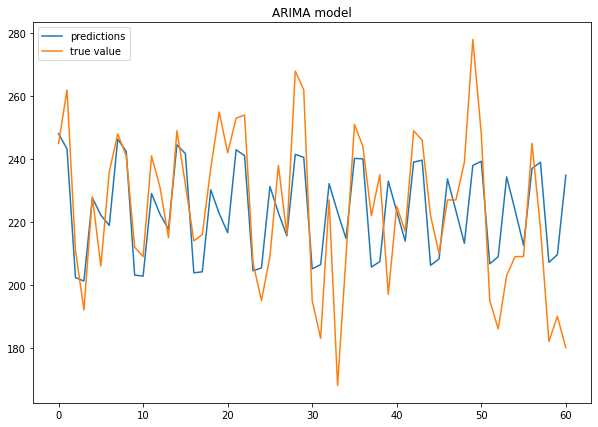

In [10]:
from statsmodels.tsa.arima.model import ARIMA # Модель ARIMA
train, test = df[df.date < split_date], df[df.date > split_date]
model = ARIMA(train['check_flow'],order=(5,1,5))
history=model.fit()
predictions = history.predict(start=len(train)+1, end=len(df)-1).values
plotting_comparison(predictions, title = 'ARIMA')

In [11]:
test_y = test.check_flow.values
print('R2 score:', r2_score(test_y, predictions))
print('MAPE:', mean_absolute_percentage_error(test_y, predictions))
print('RMSE:', (mean_squared_error(test_y, predictions))**0.5)
print('MAE: ', mean_absolute_error(test_y, predictions))
metrics_ARIMA = [[r2_score(test_y, predictions), mean_absolute_percentage_error(test_y, predictions), (mean_squared_error(test_y, predictions))**0.5, mean_absolute_error(test_y, predictions)]]

R2 score: 0.4067777477270249
MAPE: 0.06607080877246986
RMSE: 18.642114672819535
MAE:  14.219539714924048


In [13]:
df['Lastday'] = df['check_flow'].shift(+1) # Подготовка данных для Random Forest
df['Last_2_days'] = df['check_flow'].shift(+2)
df['Last_3_days'] = df['check_flow'].shift(+3)
df = df.dropna()
x1, x2, x3 = df['Lastday'].values.reshape(-1,1), df['Last_2_days'].values.reshape(-1,1), df['Last_3_days'].values.reshape(-1,1)
X = np.concatenate((x1, x2, x3), axis=1)
train_x, train_y, test_x, test_y = X[0: split_index], df.iloc[0: split_index].check_flow.values, X[split_index: len(df)], df.iloc[split_index: len(df)].check_flow.values

from sklearn.ensemble import RandomForestRegressor # функция, строящая модель Random Forest
def random_forest_predict(n_estimators, train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y):
    forest = RandomForestRegressor(n_estimators = n_estimators, max_features=3, random_state=1)
    forest.fit(train_x, train_y)
    predictions = forest.predict(test_x)
    return (mean_squared_error(test_y, predictions))**0.5, forest.predict(test_x)

optimal_trees = {n: random_forest_predict(n)[0] for n in np.arange(20,100,1)} # Словарь, в котором содержится MAE для разного количества построенных деревьев

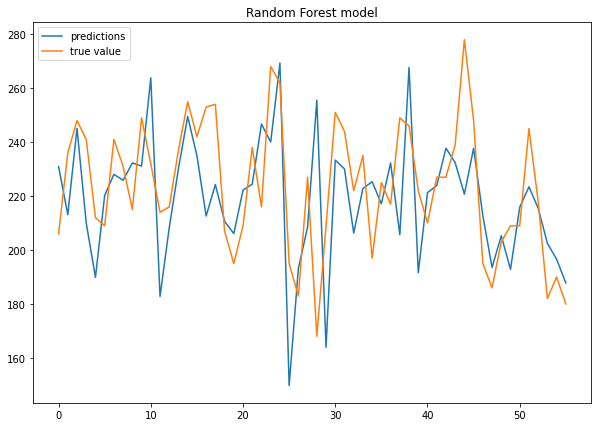

In [14]:
n = min(optimal_trees, key=optimal_trees.get) # поиск оптимального количества деревьев
predictions = random_forest_predict(n_estimators = n)[1]
plotting_comparison(predictions, title = 'Random Forest')

In [15]:
print('R2 score:', r2_score(test_y, predictions))
print('MAPE:', mean_absolute_percentage_error(test_y, predictions))
print('RMSE:', (mean_squared_error(test_y, predictions))**0.5)
print('MAE: ', mean_absolute_error(test_y, predictions))
metrics_RF = [[r2_score(test_y, predictions), mean_absolute_percentage_error(test_y, predictions), (mean_squared_error(test_y, predictions))**0.5, mean_absolute_error(test_y, predictions)]]

R2 score: -0.020805939584167765
MAPE: 0.08616032131013336
RMSE: 24.389812275971764
MAE:  18.88642857142857


In [16]:
metrics_combined = np.hstack((metrics_xgb, metrics_ARIMA, metrics_RF)).reshape(3,4)
metrics = pd.DataFrame(data = metrics_combined, columns = ['R2 score', 'MAPE', 'RMSE', 'MAE'], index = ['XGB', 'ARIMA',  'RandomForest'])
metrics 

,R2 score,MAPE,RMSE,MAE
XGB,0.489632,0.061019,17.291330,13.467908
ARIMA,0.406778,0.066071,18.642115,14.219540
RandomForest,-0.020806,0.086160,24.389812,18.886429
